# Import and Setup

In [2]:
import os
import numpy as np
import random
import tensorflow as tf
import pathlib
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras import layers, losses, activations, callbacks, optimizers
from keras.layers.experimental import preprocessing
from tensorflow.keras.models import load_model
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
    

In [3]:
print(tf.__version__)
BATCH_SIZE = 32
EPOCHS = 50
USE_GRAYSCALE = True

2.3.1


### Data Load

In [5]:
data_path = '../data'
images_dir = pathlib.Path(f'{data_path}/images')
class_names = np.array(sorted([item.name for item in images_dir.glob('*') if item.name != ".gitkeep" and item.name != ".ipynb_checkpoints"]))
print(class_names)
with open(os.path.join(data_path, 'specs.pickle'), 'rb') as f:
    spec_conv, spec_ae = pickle.load(f)

def load(name, spec):
    out_path = os.path.join(data_path, name)
    if not os.path.exists(out_path):
        raise Exception('Path does not exist')
    return tf.data.experimental.load(out_path, spec)

['bad' 'good']


### Dataset Preparation & Split

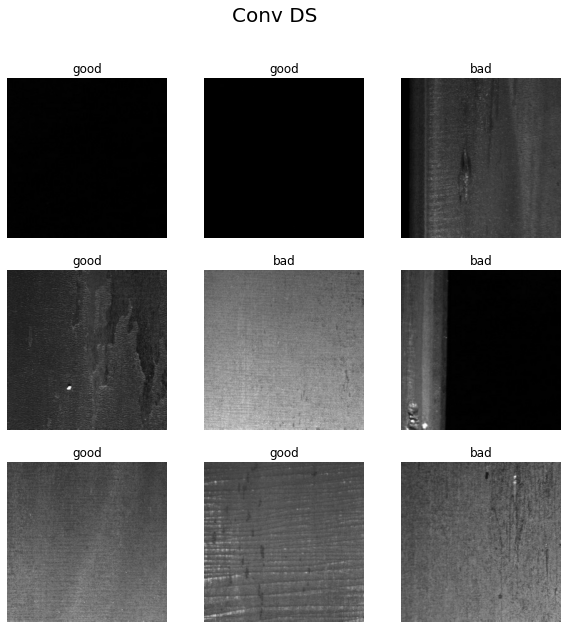

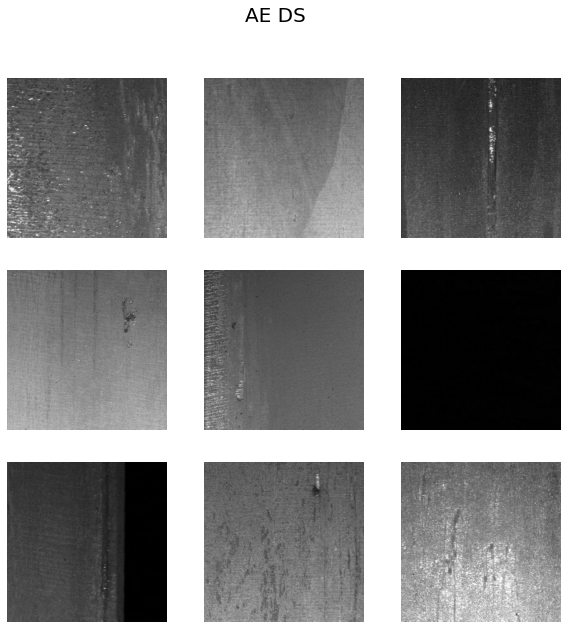

In [6]:
ae_train_ds = load('ae_train_ds', spec_ae)
ae_val_ds = load('ae_val_ds', spec_ae)
conv_train_ds = load('conv_train_ds', spec_conv)
conv_val_ds = load('conv_val_ds', spec_conv)

if USE_GRAYSCALE:
    ae_train_ds = ae_train_ds.map(lambda x, y: (tf.image.rgb_to_grayscale(x), tf.image.rgb_to_grayscale(y)))
    ae_val_ds = ae_val_ds.map(lambda x, y: (tf.image.rgb_to_grayscale(x), tf.image.rgb_to_grayscale(y)))
    conv_train_ds = conv_train_ds.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))
    conv_val_ds = conv_val_ds.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))

#AUTOTUNE = tf.data.experimental.AUTOTUNE
#def configure_for_performance(ds):
#    ds = ds.cache()
#    ds = ds.shuffle(buffer_size=1000)
#    ds = ds.prefetch(buffer_size=AUTOTUNE)
#    return ds

#conv_train_ds = configure_for_performance(conv_train_ds) 
#conv_val_ds = configure_for_performance(conv_val_ds) 
#ae_train_ds = configure_for_performance(ae_train_ds) 
#ae_val_ds = configure_for_performance(ae_val_ds) 

image_batch, label_batch = next(iter(conv_val_ds))
X_batch, _ = next(iter(ae_val_ds))

def plot_conv_ds(image_batch, label_batch, grayscale=False):
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle('Conv DS', fontsize=20)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        if grayscale:
            plt.imshow(image_batch[i].numpy().astype("uint8"), cmap='gray', vmin=0, vmax=255)
        else:
            plt.imshow(image_batch[i].numpy().astype("uint8"))
        label = label_batch[i]
        plt.title(class_names[label])
        plt.axis("off")

def plot_ae_ds(image_batch, grayscale=False):
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle('AE DS', fontsize=20)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        if grayscale:
            plt.imshow(image_batch[i].numpy().astype("uint8"), cmap='gray', vmin=0, vmax=255)
        else:
            plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")

plot_conv_ds(image_batch, label_batch, USE_GRAYSCALE)
plot_ae_ds(X_batch, USE_GRAYSCALE)

# Autoencoder Definition

In [7]:

class Autoencoder():
    @staticmethod
    def build(width, height, depth, latent_dim=32):
        input_shape = (height, width, depth)
        
        # build the encoder model
        inputs = layers.Input(shape=input_shape)
        x = layers.experimental.preprocessing.Rescaling(scale=1./127.5, offset=-1)(inputs)
        x = layers.Flatten()(x)
        latent = layers.Dense(latent_dim)(x)
        encoder = tf.keras.Model(inputs, latent, name="encoder")
        
        # build the decoder model
        latent_inputs = layers.Input(shape=(latent_dim,))
        x = layers.Dense(np.prod(input_shape))(latent_inputs)
        outputs = layers.Reshape(input_shape)(x)
        decoder = tf.keras.Model(latent_inputs, outputs, name="decoder")
        
        # build the autoencoder model
        autoencoder = tf.keras.Model(inputs, decoder(encoder(inputs)),
            name="autoencoder")
        
        return (encoder, decoder, autoencoder)
        
  
    @staticmethod
    def build_convae(width, height, depth, filters=[128,64,32,16], latent_dim=100): #HIL: check with first filter 256 to also get smaller impurities?
        input_shape = (height, width, depth)
        chan_dim = -1
        
        # Encoder
        inputs = layers.Input(shape=input_shape)
        x = inputs
            
            
        # Rescale from [0,255] to [-1,1]
        x = preprocessing.Rescaling(scale=1./255, 
                            #offset=-1,
                            name='Preprocessing_Rescale'
                           )(x) # Rescale values from [0,255] to [0,1] see https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling


        
        for f in filters:
            x = layers.Conv2D(f, (3, 3), strides=2, padding="same")(x)
            x = layers.LeakyReLU()(x)
                
        volume_size = K.int_shape(x)
        x = layers.Flatten()(x)
        latent = layers.Dense(latent_dim)(x)
        
        # build the encoder model
        encoder = tf.keras.Model(inputs, latent, name="encoder")
        
        # Decoder
        latent_inputs = layers.Input(shape=(latent_dim,))
        x = layers.Dense(np.prod(volume_size[1:]))(latent_inputs)
        x = layers.Reshape((volume_size[1], volume_size[2], volume_size[3]))(x)
        for i, f in enumerate(filters[::-1]):
            x = layers.Conv2DTranspose(f, (3, 3), strides=2, padding="same")(x)
            
            if i < len(filters) - 1:
                x = layers.LeakyReLU()(x)
            
        x = layers.Conv2D(3, kernel_size=(3,3), activation='sigmoid', padding='same')(x)
        
        outputs = preprocessing.Rescaling(scale=255.0, name='Postprocessing_Rescale')(x)
        
        # build the decoder model
        decoder = tf.keras.Model(latent_inputs, outputs, name="decoder")
        
        # build the autoencoder model
        autoencoder = tf.keras.Model(inputs, decoder(encoder(inputs)),
            name="autoencoder")
        
        return (encoder, decoder, autoencoder)
        
# Build (Dense) Autoencoder
encoder, decoder, autoencoder = Autoencoder.build(256, 256, 1 if USE_GRAYSCALE else 3, 100)


# Build Convolutional Autoencoder
conv_encoder, conv_decoder, conv_autoencoder = Autoencoder.build_convae(256, 256, 3, [128,64,32,16])
conv_encoder.summary()
conv_decoder.summary()
conv_autoencoder.summary()


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
Preprocessing_Rescale (Resca (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 128)     3584      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 64)        73792     
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 32)        1846

### Compile (Dense) Autoencoder

In [8]:
opt = optimizers.Adam(lr=1e-3)
ls = losses.MeanSquaredError()
autoencoder.compile(optimizer=opt, loss=ls, metrics=['accuracy'])

### Compile Convolutional Autoencoder

In [9]:
opt = optimizers.Adam(lr=1e-3)
ls = losses.MeanSquaredError()
conv_autoencoder.compile(optimizer=opt, loss=ls, metrics=['accuracy'])

### Callback Setup

In [7]:
from datetime import datetime

timestamp = datetime.now().isoformat()
outpath = os.path.join('..', 'log')
def get_callbacks():
        tensorboard_dir = os.path.join(outpath, f'tensorboard')
        if not os.path.exists(tensorboard_dir):
            os.makedirs(tensorboard_dir)
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_dir, histogram_freq=1)
        
        metrics_dir = os.path.join(outpath, f'metrics')
        if not os.path.exists(metrics_dir):
            os.makedirs(metrics_dir)
        csv_callback = tf.keras.callbacks.CSVLogger(filename=os.path.join(metrics_dir, f'training_log_{timestamp}.csv'))
        
        checkpoint_dir = os.path.join(outpath, f'checkpoints')
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(verbos=0, 
            filepath=os.path.join(checkpoint_dir, 'weights.{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.hdf5'),
            save_weights_only=True,
            monitor='val_loss',
            mode='auto',
            save_best_only=True,
            save_freq='epoch')

        reduce_lr_plateau_callback = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.5, 
            patience=3, 
            min_lr=0.00001)

        return [tensorboard_callback, csv_callback, checkpoint_callback, reduce_lr_plateau_callback]

# Train (Dense) Autoencoder

In [ ]:
history = autoencoder.fit(ae_train_ds,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                validation_data=ae_val_ds,
                shuffle=True,
                callbacks=get_callbacks())

Epoch 1/50
  1/266 [..............................] - ETA: 0s - loss: 9536.2002 - accuracy: 0.3275WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
225/266 [========================>.....] - ETA: 30s - loss: 8097.2510 - accuracy: 0.9895

<Figure size 432x288 with 0 Axes>

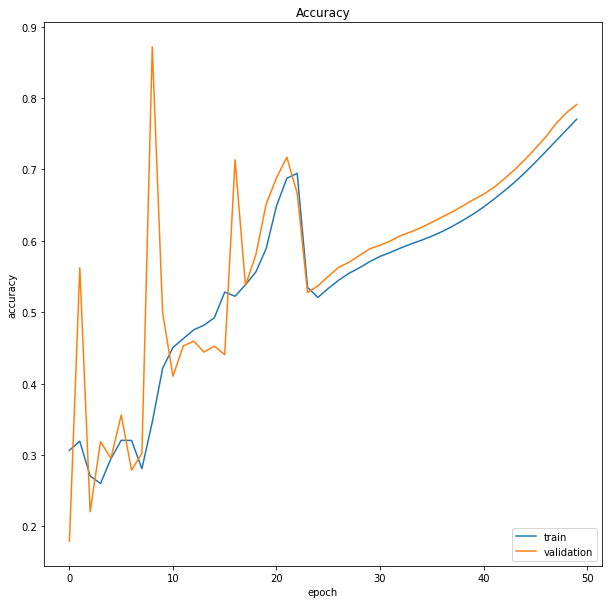

<Figure size 432x288 with 0 Axes>

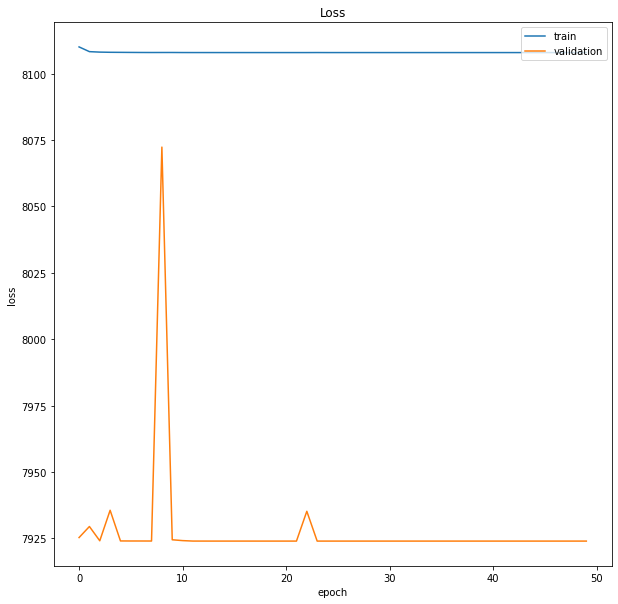

<Figure size 432x288 with 0 Axes>

In [9]:
plot_dir = os.path.join(outpath, f'plots')
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
def plot_accuracy(hist):
    plt.clf()
    plt.figure(figsize=(10,10))
    title = f"Accuracy"
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title(title)
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="lower right")
    plt.show(block=False)
    plt.savefig(os.path.join(plot_dir, f'accuracy_{timestamp}.png'))

def plot_loss(hist):
    plt.clf()
    plt.figure(figsize=(10,10))
    title = f"Loss"
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title(title)
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper right")
    plt.show(block=False)
    plt.savefig(os.path.join(plot_dir, f'loss_{timestamp}.png'))
    
def plot_metrics(history, metrics):
    if 'accuracy' in metrics:
        plot_accuracy(hist=history)
    if 'loss' in metrics:
        plot_loss(hist=history)
        
plot_metrics(history, ['accuracy', 'loss'])

In [10]:
model_save_dir = os.path.join(outpath, f'model')
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
autoencoder.save(os.path.join(model_save_dir, timestamp))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../log/model/2020-11-19T10:12:25.040745/assets


In [17]:
  
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    
    code = encoder.predict(img)[0]
    reco = decoder.predict(code)[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(tf.squeeze(img))

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(tf.squeeze(reco))
    plt.show()


### Visualise Input, Output and Deltas

In [1]:
titles = ['Original', 'Code', 'Reconstructed', 'Difference']
fig, ax = plt.subplots(nrows=9, ncols=4,figsize=(10,25))
for i, row in enumerate(ax):
    # Original
    row[0].set_title(titles[0])
    row[0].imshow(image_batch[i].numpy().astype("uint8"), cmap='gray', vmin=0, vmax=255)
    row[0].axis("off")
    
    # Code
    row[1].set_title(titles[1])
    row[1].imshow(code[i].reshape([code.shape[-1]//5,-1]).astype("uint8"))
    row[1].axis("off")
    
    # Reconstructed
    row[2].set_title(titles[2])
    row[2].imshow(reco[i].astype("uint8"), cmap='gray', vmin=0, vmax=255)
    row[2].axis("off")
    
    # Difference
    row[3].set_title(titles[3])
    diff = np.subtract(np.abs(image_batch[i].numpy()), np.abs(reco[i]))
    row[3].imshow(diff.astype("uint8"), cmap='gray', vmin=0, vmax=255)
    row[3].axis("off")

NameError: name 'plt' is not defined

# Write-Out Deltas - Dense Autoencoder

In [ ]:
encoded_conv_train = autoencoder.predict(conv_train_ds)
encoded_conv_val = autoencoder.predict(conv_val_ds)

In [15]:
def convert_train_to_conv_dataset():
    for i, ((original_image, label), reconstructed) in enumerate(zip(conv_train_ds.unbatch(), encoded_conv_train)):
        diff = np.subtract(np.abs(original_image.numpy()), np.abs(reconstructed))
        diff_tensor = tf.convert_to_tensor(diff, dtype=tf.float32)
        label = tf.one_hot(label, 2)
        yield (diff_tensor, label)

def convert_val_to_conv_dataset():
    for i, ((original_image, label), reconstructed) in enumerate(zip(conv_val_ds.unbatch(), encoded_conv_val)):
        diff = np.subtract(np.abs(original_image.numpy()), np.abs(reconstructed))
        diff_tensor = tf.convert_to_tensor(diff, dtype=tf.float32)
        label = tf.one_hot(label, 2)
        yield (diff_tensor, label)


In [ ]:
diff_conv_train_ds = tf.data.Dataset.from_generator(
    convert_train_to_conv_dataset,
    (tf.float32, tf.float32),
    ((256, 256, 1 if USE_GRAYSCALE else 3), ([2]))
)

diff_conv_val_ds = tf.data.Dataset.from_generator(
    convert_val_to_conv_dataset,
    (tf.float32, tf.float32),
    ((256, 256, 1 if USE_GRAYSCALE else 3), ([2]))
)

In [16]:
def save(ds, name):
    out_path = os.path.join(data_path, name)
    if os.path.exists(out_path):
        raise Exception('Path exists already')
    tf.data.experimental.save(ds, out_path)

In [ ]:
save(diff_conv_train_ds, 'diff_conv_train_ds') 
save(diff_conv_val_ds, 'diff_conv_val_ds') 

In [ ]:
elem_spec_diff = diff_conv_train_ds.element_spec
with open(os.path.join(data_path, 'diff_specs.pickle'), 'wb') as f:
    pickle.dump(elem_spec_diff, f)

In [ ]:
elem_spec_diff

# Train Convolutional Autoencoder

In [ ]:
timestamp = datetime.now().isoformat()
outpath = os.path.join('..', 'log')
history = conv_autoencoder.fit(ae_train_ds,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                validation_data=ae_val_ds,
                shuffle=True,
                callbacks=get_callbacks())

In [ ]:
plot_dir = os.path.join(outpath, f'plots')
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
plot_metrics(history, ['accuracy', 'loss'])

In [ ]:
model_save_dir = os.path.join(outpath, f'model')
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
conv_autoencoder.save(os.path.join(model_save_dir, timestamp))

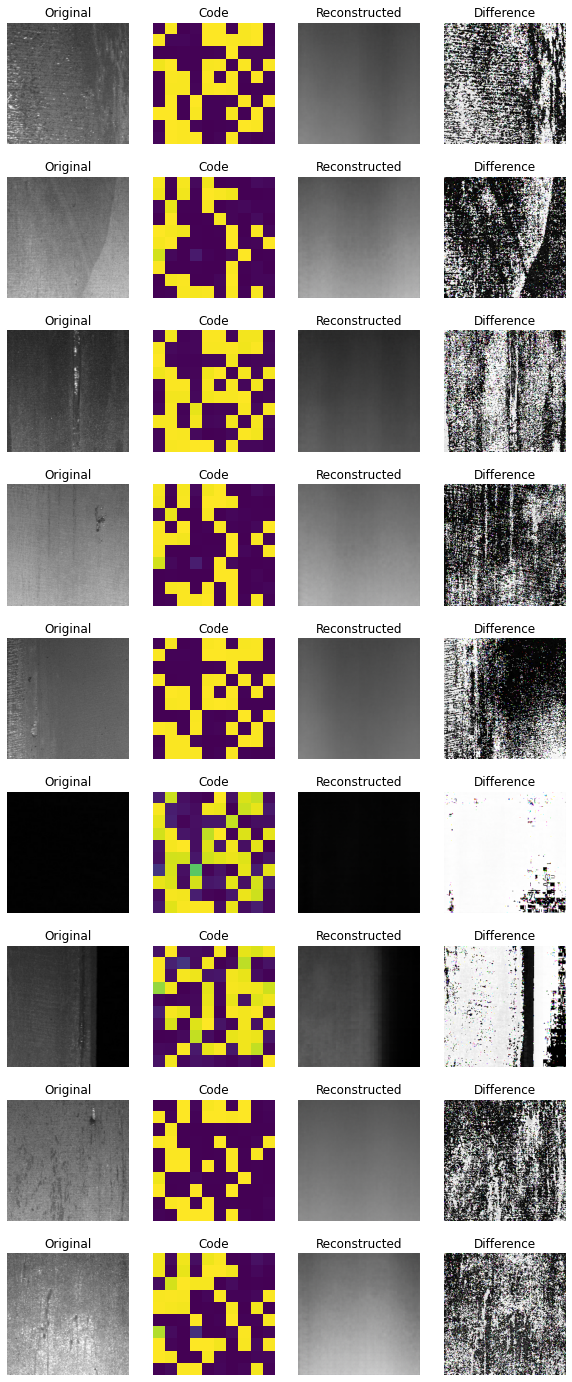

In [12]:

ae_val_ds = load('ae_val_ds', spec_ae)


image_batch, _ = next(iter(ae_val_ds))
#load model
#ae = load_model('../log/model/2020-11-19T17:58:11.158397')
#ae.save_weights('../ckpts/convae_weights')

# load weights saved from model '../log/model/2020-11-19T17:58:11.158397'
conv_autoencoder.load_weights('../ckpts/convae_weights')

code = conv_encoder.predict(image_batch)
reco = conv_decoder.predict(code)


titles = ['Original', 'Code', 'Reconstructed', 'Difference']
fig, ax = plt.subplots(nrows=9, ncols=4,figsize=(10,25))
for i, row in enumerate(ax):
    # Original
    row[0].set_title(titles[0])
    row[0].imshow(image_batch[i].numpy().astype("uint8"), cmap='gray', vmin=0, vmax=255)
    row[0].axis("off")
    
    # Code
    row[1].set_title(titles[1])
    row[1].imshow(code[i].reshape([code.shape[-1]//10,-1]).astype("uint8"))
    row[1].axis("off")
    
    # Reconstructed
    row[2].set_title(titles[2])
    row[2].imshow(reco[i].astype("uint8"), cmap='gray', vmin=0, vmax=255)
    row[2].axis("off")
    
    # Difference
    row[3].set_title(titles[3])
    diff = np.subtract(np.abs(image_batch[i].numpy()), np.abs(reco[i]))
    row[3].imshow(diff.astype("uint8"), cmap='gray', vmin=0, vmax=255)
    row[3].axis("off")
    

### Write-Out Convolutional Autoencoder Deltas

In [17]:
# load original RGB dataset since convolutional AE expects that
conv_train_ds = load('conv_train_ds', spec_conv)
conv_val_ds = load('conv_val_ds', spec_conv)

# create output of convolutional AE
encoded_conv_train = conv_autoencoder.predict(conv_train_ds)
encoded_conv_val = conv_autoencoder.predict(conv_val_ds)

# calculate 'difference mask' i.e. pixel differences between original picture and ConvAE output
diff_conv_train_ds = tf.data.Dataset.from_generator(
    convert_train_to_conv_dataset,
    (tf.float32, tf.float32),
    ((256, 256, 3), ([2]))
)

diff_conv_val_ds = tf.data.Dataset.from_generator(
    convert_val_to_conv_dataset,
    (tf.float32, tf.float32),
    ((256, 256, 3), ([2]))
)

# Save    
save(diff_conv_train_ds, 'diff_conv_train_ds_convae') 
save(diff_conv_val_ds, 'diff_conv_val_ds_convae') 